<a href="https://colab.research.google.com/github/senabyengec/Supervised-Contrastive-for-Classification-of-Colorectal-Polyps-on-Histopathological-Images/blob/main/an_effective_colorectal_polyp_classification_for_histopathological_images_based_on_supervised_contrastive_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An Effective Colorectal Polyp Classification for Histopathological Images Based on Supervised Contrastive Learning

**Author:** Sena Yengec-Tasdemir

Doi:(under revision)
(Last edited: 03/01/2024)


# Introduction

### Overview
This notebook presents an implementation of the "An Effective Colorectal Polyp Classification for Histopathological Images" article. Our focus is on constructing a [Supervised Contrastive Learning](https://arxiv.org/abs/2004.11362) (Sup-Con) model, specifically designed for classifying colorectal polyps in colon histopathology images.

### Model Architecture
The proposed model enhances the standard Sup-Con framework with several architectural modifications. Key among these is the integration of the Big Transfer (BiT) encoder. We further refine the model in a second stage by introducing an intricate sequence of layers, including dropout layers and a fully connected layer equipped with L2 kernel regularizers. The architecture culminates in a softmax layer for final classification.

### Optimization and Loss Function
For optimization, we employ Stochastic Gradient Descent (SGD), carefully calibrated with an optimal learning rate and momentum. The model's robustness and accuracy are further boosted by our choice of loss function: categorical cross-entropy with label smoothing. This choice not only enhances prediction accuracy but also improves the model's adaptability in various scenarios.

Dependencies
This implementation requires TensorFlow Addons, which can be installed via pip:

pip install tensorflow-addons


### Requirements
*   The dataset need to be uploaded to Google Drive folder. The following paths need to be updated accordingly.
*   Wandb is used for plots. One needs to either have a Wandb account or remove those lines of code.

In [ ]:
!pip install tensorflow-addons

In [ ]:
# install TF addons if needed
try:
    import tensorflow_addons as tfa  # main package
except ModuleNotFoundError:
    !pip install tensorflow-addons
    import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 12.2 MB/s 


In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub


In [ ]:
!pip install wandb
!wandb login

## Set up the  dataset


In [ ]:
from google.colab import drive
from pathlib import Path
import os
drive.mount('/content/drive')

Mounted at /content/drive


### Choose dataset to work with
In here, we are experimenting on the same dataset with different normalization methods.



The structure of the Datasets:

    path/to/image_dir/
    split_name/  # Ex: 'train'
    label1/  # Ex: 'adenom' or 'nonAdenom'
      xxx.png
      xxy.png
      xxz.png
    label2/
      xxx.png
      xxy.png
      xxz.png
    split_name/  # Ex: 'val'
    ...
    split_name/  # Ex: 'test'
    ...

In [ ]:
dataset_name = "custom_ds_3_class" # @param ["custom_ds_3_class","clahe",'stain-net','public', 'vanilla', 'stain-gan', 'reinhard', 'macenko', 'vahande']

dateset_handle_map = {
  "stain-net": "/content/drive/MyDrive/histo/labeled_stainet_normalized_train_test_val/",
  "public" : "/content/drive/MyDrive/histo/UnitoPatho/",
  "stain-gan": "/content/drive/MyDrive/histo/labeled_staingan_normalized_train_test_val/",
  "reinhard": "/content/drive/MyDrive/histo/labeled_reinhard_normalized_train_test_val/",
  "macenko": "/content/drive/MyDrive/histo/labeled_macenko_normalized_train_test_val/",
  "vahande": "/content/drive/MyDrive/histo/labeled_vahande_normalized_train_test_val/",
  "clahe" : "/content/drive/MyDrive/histo/labeled_clahe_normalized_train_test_val/",
  "custom_ds_3_class": "/content/drive/MyDrive/histo/custom_ds_3_class_train_test_val/",
}
dataset_handle = dateset_handle_map.get(dataset_name)
path_data = Path(dataset_handle)
dest = path_data
data_dir = path_data

In [ ]:
dataset_handle

'/content/drive/MyDrive/PHD/tez/histo/cropped_after_labeling_val_eliminated/'

In [ ]:
dest = path_data
data_dir = path_data
BATCH_SIZE = 16
IMG_SIZE = 224
IMAGE_SIZE = (IMG_SIZE,IMG_SIZE)
input_shape = (IMG_SIZE, IMG_SIZE, 3)

In [ ]:
def build_dataset(subset, data_dir):
  return tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      label_mode="categorical",
      # Seed needs to provided when using validation_split and shuffle = True.
      # A fixed seed is used so that the validation set is stable across runs.
      seed=123,
      image_size=IMAGE_SIZE,
      batch_size=1)
train_ds_path = os.path.join(data_dir, "train")
train_ds = build_dataset("training", train_ds_path)
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()
#For vit rescale between -1,1 for cnn 0,1, ViT: scale=1./127.5, offset=-1
normalization_layer = tf.keras.layers.Rescaling(scale=1./255)
#normalization_layer = tf.keras.layers.Rescaling(scale=1./127.5,offset=-1)
preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  preprocessing_model.add(
      tf.keras.layers.RandomRotation(40))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0.2, 0))
  # Like the old tf.keras.preprocessing.image.ImageDataGenerator(),
  # image sizes are fixed when reading, and then a random zoom is applied.
  # If all training inputs are larger than image_size, one could also use
  # RandomCrop with a batch size of 1 and rebatch later.
  preprocessing_model.add(
      tf.keras.layers.RandomFlip(mode="horizontal"))

train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))

val_ds_path= os.path.join(data_dir, 'val')
val_ds_1 = build_dataset("validation",val_ds_path)
valid_size = val_ds_1.cardinality().numpy()
val_ds_1 = val_ds_1.unbatch().batch(BATCH_SIZE)
val_ds = val_ds_1.map(lambda images, labels:
                    (normalization_layer(images), labels))

test_ds_path= os.path.join(data_dir, 'test')
test_ds_1 = build_dataset("test",val_ds_path)
test_size = test_ds_1.cardinality().numpy()
test_ds_1 = test_ds_1.unbatch().batch(BATCH_SIZE)
test_ds = test_ds_1.map(lambda images, labels:
                    (normalization_layer(images), labels))


num_classes = len(class_names)

Plot a sample image from the validation set

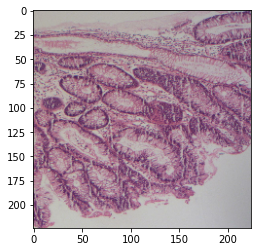

In [ ]:
import matplotlib.pylab as plt
import numpy as np
x, y = next(iter(val_ds))
img = x[2, :, :, :]

plt.imshow(img)
plt.show()


Including image data augmentation for stage 1 of Sup-Con

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.02),
        layers.RandomWidth(0.2),
        layers.RandomHeight(0.2),
    ]
)



## Build the encoder model

The encoder model takes the image as input and turns it into a 2048-dimensional
feature vector.

In [ ]:
def create_encoder():
    """
    resnet = keras.applications.ResNet50V2(
        include_top=False, weights='imagenet', input_shape=input_shape, pooling="avg"
    )
    """
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
        hub.KerasLayer("https://tfhub.dev/google/bit/m-r50x1/1", trainable=True)])
    model.build((None,)+IMAGE_SIZE+(3,))
    return model


encoder = create_encoder()
encoder.summary()

learning_rate = 0.001
batch_size = 16
hidden_units = 512
projection_units = 128
num_epochs = 2
dropout_rate = 0.1
temperature = 0.05


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              23500352  
                                                                 
Total params: 23,500,352
Trainable params: 23,500,352
Non-trainable params: 0
_________________________________________________________________


## Build the classification model

The classification model adds a fully-connected layer on top of the encoder,
plus a softmax layer with the target classes.

In [ ]:
def create_classifier(encoder, trainable=True):
  for layer in encoder.layers:
    layer.trainable = trainable
    model = tf.keras.Sequential([
      tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
      encoder,
      tf.keras.layers.Dropout(rate=0.1),
      tf.keras.layers.Dense(hidden_units, activation="relu",kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
      tf.keras.layers.Dropout(rate=0.1),
      layers.Dense(len(class_names),kernel_regularizer=tf.keras.regularizers.l2(0.0001))])
  model.build((None,)+IMAGE_SIZE+(3,))
  model.compile(
      optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
      metrics=['accuracy', tf.keras.metrics.CategoricalCrossentropy(name="categorical_crossentropy", from_logits=True, label_smoothing=0.1)])
  return model


## Experiment 1: Supervised Learning-Based Baseline Classifier Training

This experiment focuses on training a baseline classifier using Supervised Learning. In this approach, both the encoder and classifier components are integrated into a unified model. The primary objective is to minimize the cross-entropy loss during the training process.

In [ ]:
encoder = create_encoder()
classifier = create_classifier(encoder)
classifier.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 2048)              23500352  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 24,550,979
Trainable params: 24,550,979
Non-trainable params: 0
_________________________________________________________________


In [ ]:
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
do_class_weighting = False #@param {type:"boolean"}
checkpoint_filepath = '/content/drive/MyDrive/best_model_check_point/'
#checkpoint = ModelCheckpoint('model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,save_weights_only = True,
    monitor='val_accuracy',mode='max',save_best_only=True)

if do_class_weighting:
  neg, pos, pos1 = 125, 321, 84 #[446, 2881, 2250]
  total = neg + pos + pos1
  weight_for_0 = (total) / (len(class_names) * neg)
  weight_for_1 = (total) / (len(class_names) * pos)
  weight_for_2 = (total) / (len(class_names) * pos1)

  #n_samples / (n_classes * np.bincount(y))
  #weight_for_2 = (1 / pos1) * (total / 2.0)
  class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2,}
  print('Weight for class 0: {:.2f}'.format(weight_for_0))
  print('Weight for class 1: {:.2f}'.format(weight_for_1))
  print('Weight for class 2: {:.2f}'.format(weight_for_2))
  hist = classifier.fit(
      train_ds,
      epochs=2, steps_per_epoch=steps_per_epoch,
      validation_data=val_ds,
      validation_steps=validation_steps, class_weight=class_weight)
else:
  hist = classifier.fit(
      train_ds,
      epochs=10, steps_per_epoch=steps_per_epoch,
      validation_data=val_ds,
      validation_steps=validation_steps)#, callbacks=[model_checkpoint_callback]) #, callbacks=[WandbCallback()])
      # validation_steps=validation_steps, callbacks=[WandbCallback(),model_checkpoint_callback])
      #to save the best model and use it in the next stes uncomment the code above


## Experiment 2: Two-Phase Training of the Proposed Sup-Con Model

This experiment involves a two-stage training process for the proposed Sup-Con model.

### Phase 1: Pretraining the Encoder
Initially, the BiT encoder is pretrained, focusing on optimizing the supervised contrastive loss. This approach is based on the methodology described by [Prannay Khosla et al.](https://arxiv.org/abs/2004.11362), detailed in their research.

### Phase 2: Enhanced Classifier Training with a Frozen Encoder
In the second phase, the classifier is trained using the pretrained encoder, whose weights are frozen to preserve their optimized state. During this phase, the model undergoes further refinement with an elaborate sequence of layers, including dropout layers and a fully connected layer equipped with L2 kernel regularizers, culminating in a softmax layer for final classification. Here, the training focuses exclusively on optimizing the weights of the fully-connected layers and the softmax layer.

Optimization and Loss Function
For optimization, Stochastic Gradient Descent (SGD) is employed, precisely calibrated with an optimal learning rate and momentum. The robustness and accuracy of the model are significantly enhanced by our choice of loss function: categorical cross-entropy with label smoothing. This choice not only augments prediction accuracy but also bolsters the model's adaptability in histopathology images.

In [ ]:
class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        labels = tf.argmax(labels, axis=1)
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)


def add_projection_head(encoder):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
        encoder,
        tf.keras.layers.Dense(projection_units, activation="relu",kernel_regularizer=tf.keras.regularizers.l2(0.0001))])
    model.build((None,)+IMAGE_SIZE+(3,))
    return model


### 2. Pretrain the encoder

In [ ]:
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
encoder = create_encoder()
encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
    loss=SupervisedContrastiveLoss(temperature))


encoder_with_projection_head.summary()

history = encoder_with_projection_head.fit(
      train_ds,
      epochs=100, steps_per_epoch=steps_per_epoch,
      validation_data=val_ds,
      validation_steps=validation_steps)

### 3. Train the classifier with the frozen encoder

In [ ]:
import wandb
from wandb.keras import WandbCallback


wandb.config = {
  "dataset" : dataset_name,
  "model_architecture" : "bit_sup_con",
  "fine_tune" : True,
  "epochs": 100,
  "batch_size": BATCH_SIZE
}
wandb.init(config=wandb.config)


In [ ]:
classifier = create_classifier(encoder, trainable=False)

hist = classifier.fit(
      train_ds,
      epochs=100, steps_per_epoch=steps_per_epoch,
      validation_data=val_ds,
      validation_steps=validation_steps)

accuracy = classifier.evaluate(test_ds)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

We get to an improved test accuracy.

## Run this only for BiT with Sup-Con since it cannot use the WandB callbacks during fit

In [ ]:
num_steps = hist.params['epochs']
xs = [ i for i in range(num_steps) ]
#wandb.log({'loss': 0.2}, step=step)

#wandb.log({"loss1": hist.history['loss']},  step=num_steps)
for i in xs:
  log_dict = {
      "loss": hist.history['loss'][i],
      "epoch": i,
  }
  wandb.log(log_dict)

for i in xs:
  log_dict = {
      "val_loss": hist.history['val_loss'][i],
      "epoch": i,
  }
  wandb.log(log_dict)


for i in xs:
  log_dict = {
      "accuracy": hist.history['accuracy'][i],
      "epoch": i,
  }
  wandb.log(log_dict)

for i in xs:
  log_dict = {
      "val_accuracy": hist.history['val_accuracy'][i],
      "epoch": i,
  }
  wandb.log(log_dict)


Confusion Martix


---



In [ ]:
##The confusion matrix

flat_class_names = [k for k in class_names]
test_ds, test_labels = next(iter(test_ds))
test_ds, test_labels = zip(*((x,y) for x,y in val_ds))
test_ds, test_labels = np.vstack(test_ds), np.vstack(test_labels)

test_predictions = ensemble_model.predict(test_ds)
ground_truth_class_ids = test_labels.argmax(axis=1)
# take the argmax for each set of prediction scores
# to return the class id of the highest confidence prediction
top_pred_ids = test_predictions.argmax(axis=1)

# Log confusion matrix
# the key "conf_mat" is the id of the plot--do not change
# this if you want subsequent runs to show up on the same plot
"""wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,
                        preds=top_pred_ids, y_true=ground_truth_class_ids,
                        class_names=flat_class_names)})"""

'wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,\n                        preds=top_pred_ids, y_true=ground_truth_class_ids,\n                        class_names=flat_class_names)})'

In [ ]:
tf.shape(ground_truth_class_ids)

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([208], dtype=int32)>

In [ ]:
# ROC
wandb.log({"roc" : wandb.plot.roc_curve(ground_truth_class_ids, test_predictions, labels=flat_class_names, classes_to_plot=None)})


In [ ]:
wandb.log({"roc_curve" : wandb.plot.roc_curve(ground_truth_class_ids, test_predictions, labels=flat_class_names)})

In [ ]:
# ROC
wandb.log({"pr" : wandb.plot.pr_curve(ground_truth_class_ids, test_predictions,labels=flat_class_names, classes_to_plot=None)})

In [ ]:
# Learning Curve
#wandb.sklearn.plot_learning_curve(nb, X_test, y_test)

y_pred = top_pred_ids.reshape(1,-1)
y_test = ground_truth_class_ids.reshape(1,-1)
# Confusion Matrix
#wandb.sklearn.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), labels=flat_class_names)

In [ ]:
wandb.sklearn.plot_confusion_matrix(top_pred_ids, ground_truth_class_ids, labels=flat_class_names)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(top_pred_ids, ground_truth_class_ids)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=flat_class_names)
disp.plot()
plt.show()
#wandb.log({'heatmap_with_text': wandb.plots.HeatMap(flat_class_names, flat_class_names, cm, show_text=False)})


## Continue as usual

In [ ]:
accuracy = classifier.evaluate(test_ds)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

flat_class_names = [k for k in class_names]
test_data, test_labels = next(iter(test_ds))
test_data, test_labels = zip(*((x,y) for x,y in test_ds))
test_data, test_labels = np.vstack(test_data), np.vstack(test_labels)

test_predictions = classifier.predict(test_data)
ground_truth_class_ids = test_labels.argmax(axis=1)
# take the argmax for each set of prediction scores
# to return the class id of the highest confidence prediction
top_pred_ids = test_predictions.argmax(axis=1)

y_pred = top_pred_ids.reshape(1,-1)
y_test = ground_truth_class_ids.reshape(1,-1)
# Confusion Matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(top_pred_ids, ground_truth_class_ids)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=flat_class_names)
disp.plot()
plt.savefig("/content/drive/MyDrive/best_model_check_point/best_model.png")
plt.show()